In [2]:
# load data and metadata from saved files, combine them, and display unique labels
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt

# from glitchstream.glitch_downloader import GlitchDownloader
# from glitchstream.deepextractor import DeepExtractor

base_dir = pathlib.Path('./sample_glitches')

data_subs = []
for i in range(1):
	data_subs.append(np.load(base_dir/f'random_glitches_{i}_g_hats.npy',allow_pickle=True))
data = np.concatenate(data_subs,axis=0)

print(data.shape)

metadatas = []
for i in range(1):
	metadatas.append(pd.read_csv(base_dir/f'random_glitches_{i}_metadataframe.csv'))
metadata_df = pd.DataFrame(pd.concat(metadatas,ignore_index=True))

ghat_labels = metadata_df['ml_label'].to_numpy()
ghat_labels_uq = np.unique(ghat_labels)
print(np.unique(metadata_df['ml_label'].to_numpy()))

ghat_df = pd.DataFrame({'ghat':list(data),'label':ghat_labels})

ghat_df.head()

(2000, 8192)
['Blip' 'Koi_Fish' 'Scattered_Light' 'Tomte']


,ghat,label
0,"[-0.6649329863064288, -0.013300431395350643, -...",Tomte
1,"[-1.5218259913611227, 2.1265724069141783, 1.36...",Scattered_Light
2,"[1.0539129622272867, -0.062193694494517615, 3....",Blip
3,"[2.8798052331645216, 1.2827490522864409, 0.380...",Tomte
4,"[3.6875115093197017, -0.8832482481496595, 3.89...",Scattered_Light


In [ ]:
# transform data into train and test sets | in tslearn format for K-Shape clustering
import tslearn

from sklearn.model_selection import train_test_split
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tslearn.clustering import KShape

np.random.seed(42)

df_train, df_test = train_test_split(ghat_df, train_size=0.8, random_state=42,stratify=ghat_df['label'],shuffle=True)

ghat_train = np.array(df_train.ghat.to_list())
label_train = np.array(df_train.label.to_list())
ghat_test = np.array(df_test.ghat.to_list())
label_test = np.array(df_test.label.to_list())


X_train_ts = to_time_series_dataset(ghat_train)
X_test_ts = to_time_series_dataset(ghat_test)

X_train_ts_resampled = TimeSeriesResampler(sz=2048).fit_transform(X_train_ts)
X_test_ts_resampled = TimeSeriesResampler(sz=2048).fit_transform(X_test_ts)

X_train_ts_scaled = TimeSeriesScalerMeanVariance().fit_transform(X_train_ts_resampled) # scale each time series to zero mean and unit variance

X_types = []
for i in range(len(ghat_labels_uq)):
    X_types.append(X_train_ts_scaled[label_train == ghat_labels_uq[i]])

# create initial centroids for KShape, from each 4 glitch classes; Random initialization left to be tested
X_init_ls = []
for i in range(len(X_types)):
    X_init_ls.append(X_types[i][np.random.randint(X_types[i].shape[0])])
X_init = np.array(X_init_ls)
ks = KShape(n_clusters=len(ghat_labels_uq),random_state=42,init=X_init)
y_pred_ks = ks.fit_predict(X_train_ts_scaled)



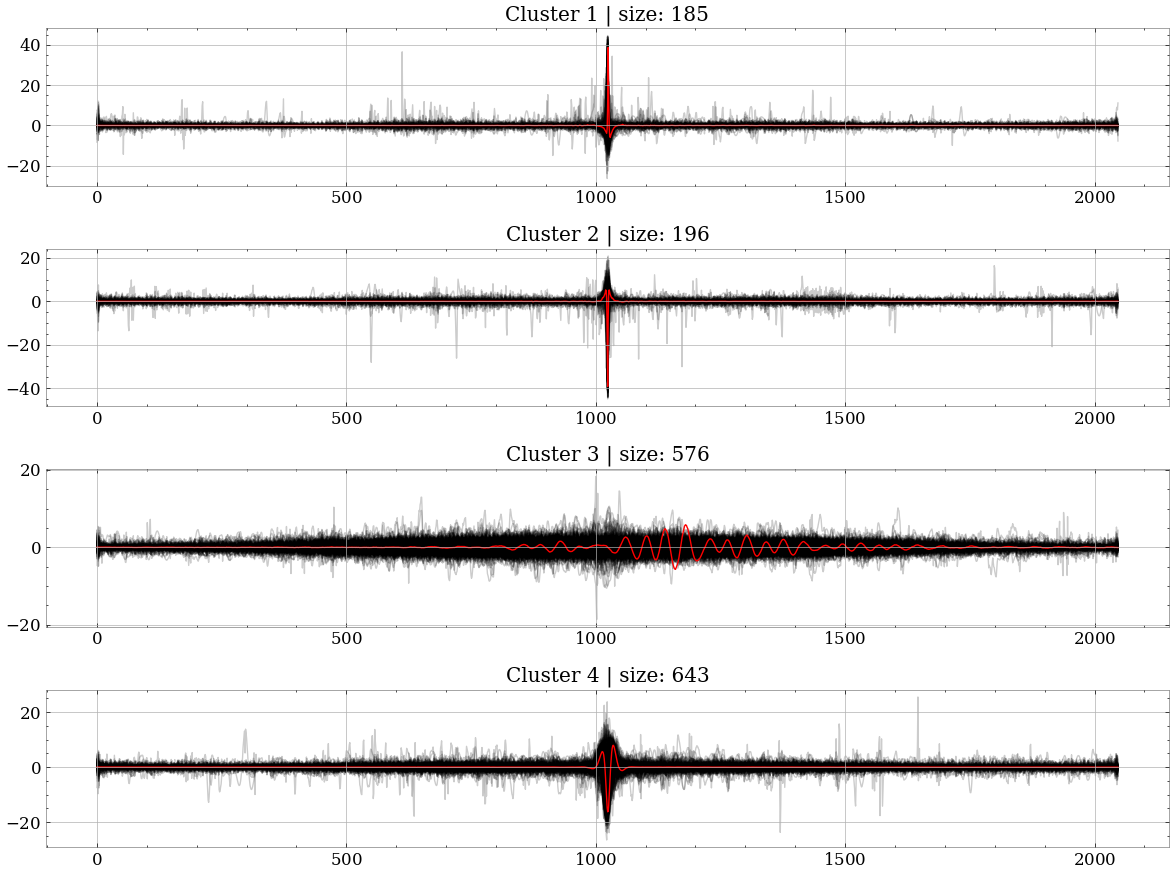

In [ ]:
plt.figure(figsize=(12,9))

for yi in range(len(ghat_labels_uq)):
    plt.subplot(len(ghat_labels_uq),1,yi+1)
    for xx in X_train_ts_scaled[y_pred_ks == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.title(f"Cluster {yi+1} | size: {np.sum(y_pred_ks==yi)}")
plt.tight_layout()
plt.show()

In [ ]:
# here we do NOT assign initial centroids from known labeled classes, but pick random init and try for 10 times
ks_random = KShape(n_clusters=len(ghat_labels_uq),random_state=42,n_init=10,init='random')
y_pred_ks_random = ks_random.fit_predict(X_train_ts_scaled)

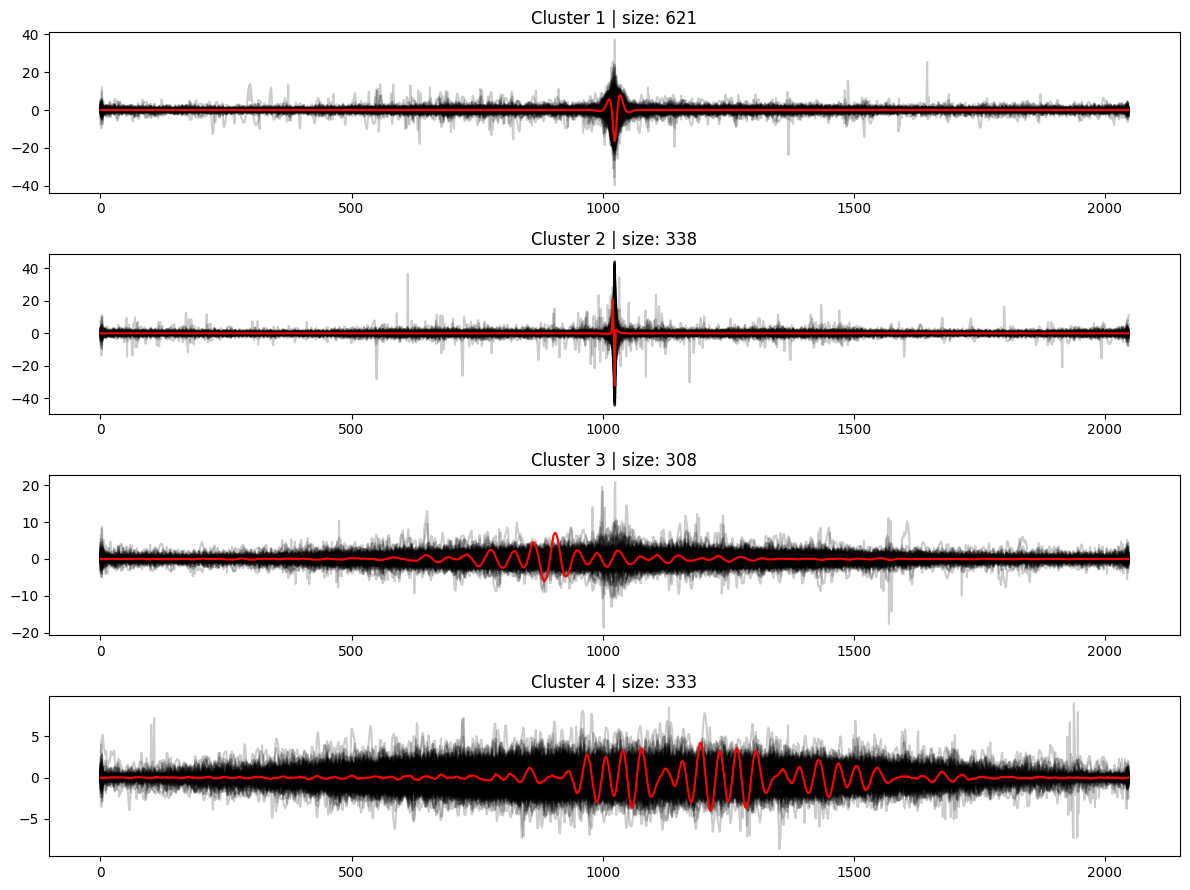

In [22]:
label_uq_ksrandom = np.unique(y_pred_ks_random)
plt.figure(figsize=(12,9))

for yi in range(len(label_uq_ksrandom)):
    plt.subplot(len(label_uq_ksrandom),1,yi+1)
    for xx in X_train_ts_scaled[y_pred_ks_random == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks_random.cluster_centers_[yi].ravel(), "r-")
    plt.title(f"Cluster {yi+1} | size: {np.sum(y_pred_ks_random==yi)}")
plt.tight_layout()
plt.show()

In [ ]:
# save the trained KShape models
import pathlib

model_dir = pathlib.Path('./kshape_models')
model_dir.mkdir(parents=True,exist_ok=True)
ks.to_pickle(model_dir/'kshape_model_initialized_with_gravity_spy_labels.pkl')
ks_random.to_pickle(model_dir/'kshape_model_random_initialization.pkl')

In [ ]:
# half-supervised kshape clustering, centroid initialization consist of known labels + randomly selected samples

from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tslearn.clustering import KShape
from tslearn.metrics import cdist_normalized_cc

np.random.seed(42)

df_train, df_test = train_test_split(ghat_df, train_size=0.8, random_state=42,stratify=ghat_df['label'],shuffle=True)

ghat_train = np.array(df_train.ghat.to_list())
label_train = np.array(df_train.label.to_list())
ghat_test = np.array(df_test.ghat.to_list())
label_test = np.array(df_test.label.to_list())


X_train_ts = to_time_series_dataset(ghat_train)
X_test_ts = to_time_series_dataset(ghat_test)

# resample timeseries to smaller size for faster computation
sz_resample = 2048
X_train_ts_resampled = TimeSeriesResampler(sz=sz_resample).fit_transform(X_train_ts)
X_train_ts_scaled = TimeSeriesScalerMeanVariance().fit_transform(X_train_ts_resampled)

k_range = range(3,10) # number of clusters to try 3,4,5,6,7,8,9
inertia_list = []
ARI_list = []

known_centroids = []

ks_half_supervised_list = []
y_pred_ks_half_supervised_list = []
init_centroids_list = []

for i in range(len(ghat_labels_uq)):
    X_subset = X_train_ts_scaled[label_train == ghat_labels_uq[i]]
    ks_subset = KShape(n_clusters=1,random_state=42,init='random')
    ks_subset.fit(X_subset)
    known_centroids.append(ks_subset.cluster_centers_[0]) # get centroid for each known labeled class

# define a function to pick random samples as initial centroids for unknown clusters, we need to make sure their distances from
# known centroids are large enough than certain threshold (to avoid overlapping clusters)
def sbd_distance_matrix(X,Y):
    X_norms = np.linalg.norm(X,axis=(1,2))
    Y_norms = np.linalg.norm(Y,axis=(1,2))
    ncc_matrix = cdist_normalized_cc(X,Y,norms1=X_norms,norms2=Y_norms,self_similarity=False)
    return 1. - ncc_matrix

def find_safe_random_sample(X,known_centroids,random_centroids,threshold=0.75):  # eats input centroids list and appends a new safe random sample
    max_tries = 1000
    if len(random_centroids) > 0:
        known_centroids = known_centroids + random_centroids # exclude both known and already selected random centroids
    for _ in range(max_tries):
        rand_idx = np.random.randint(X.shape[0])
        candidate = X[rand_idx].reshape(1,-1,1)
        dists = sbd_distance_matrix(candidate,np.array(known_centroids))
        if np.min(dists) >= threshold:
            new_centroid = candidate.reshape(sz_resample,1)
            return new_centroid
    raise ValueError("Could not find a safe random sample after maximum tries") # if not found within max tries, raise error and abort




for k in k_range:
    if k < len(ghat_labels_uq):
        ks_half_supervised = KShape(n_clusters=k,random_state=42,init='random',n_init=10) # if k less than known clusters, random initialize
    else:
        n_random = k - len(ghat_labels_uq) # number of unknown clusters to add
        random_centroids = []
        for j in range(n_random): # begin from known centroids, add random centroids one by one
            rand_cent = find_safe_random_sample(X_train_ts_scaled,known_centroids,random_centroids)
            random_centroids.append(rand_cent)
        init_centroids = np.array(known_centroids + random_centroids)
        ks_half_supervised = KShape(n_clusters=k,random_state=42,init=init_centroids)
    y_pred_ks_half_supervised = ks_half_supervised.fit_predict(X_train_ts_scaled)
    ks_half_supervised_list.append(ks_half_supervised)
    y_pred_ks_half_supervised_list.append(y_pred_ks_half_supervised)
    init_centroids_list.append(init_centroids)
    inertia_list.append(ks_half_supervised.inertia_)
    ARI_list.append(adjusted_rand_score(label_train,y_pred_ks_half_supervised)) # compare predicted labels with known labels



In [379]:
for ks in ks_half_supervised_list:
    ks.to_pickle(model_dir/f'k{ks.n_clusters}_kshape_half_supervised_model.pkl')

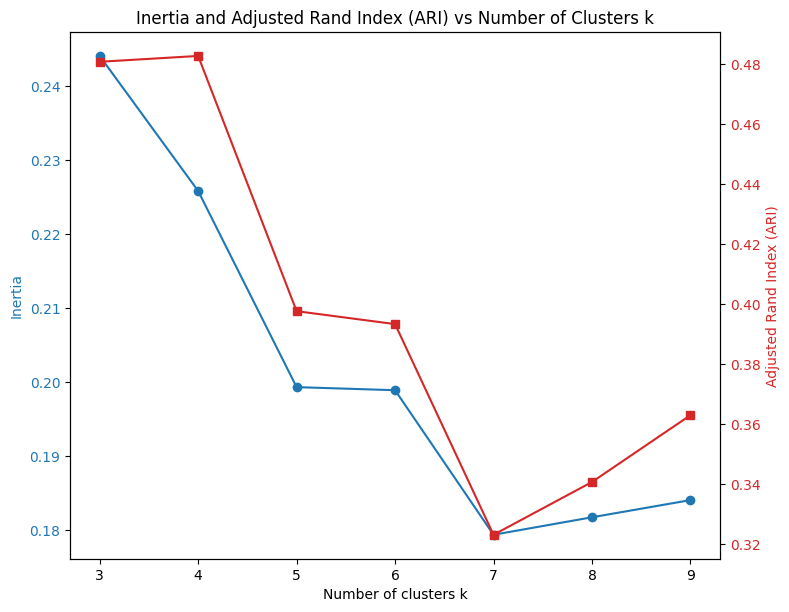

In [359]:
fig, ax1 = plt.figure(figsize=(8,6)), plt.gca()

ax1.set_xlabel('Number of clusters k')
ax1.set_ylabel('Inertia', color='tab:blue')
ax1.plot(k_range, inertia_list, marker='o', color='tab:blue', label='Inertia')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Adjusted Rand Index (ARI)', color='tab:red')
ax2.plot(k_range, ARI_list, marker='s', color='tab:red', label='ARI')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Inertia and Adjusted Rand Index (ARI) vs Number of Clusters k')
plt.show() 

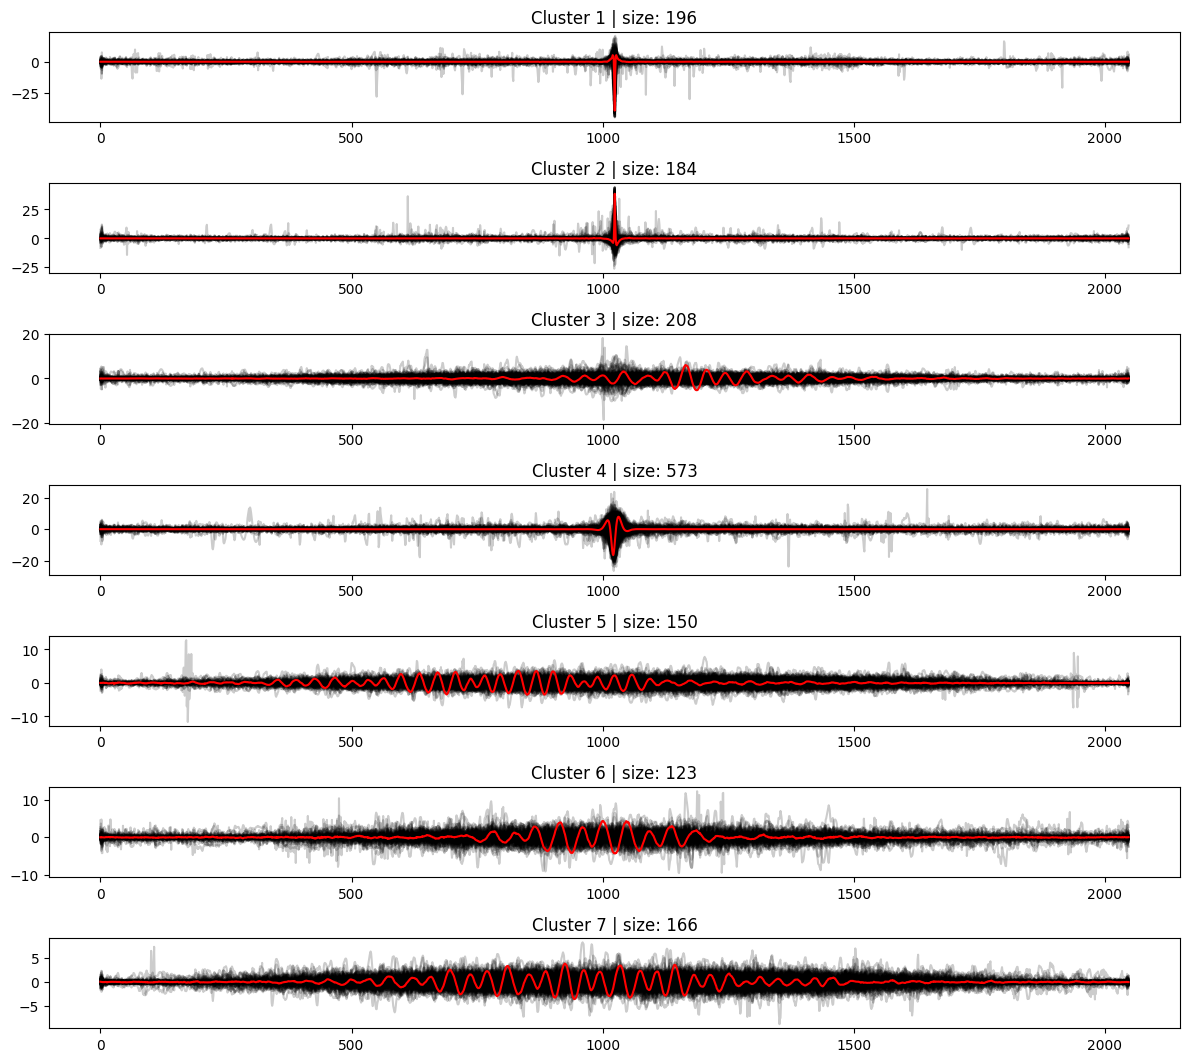

In [371]:
# draw cluster centeroids for kbest-1, k, kbest+1 from elbow method and ARI

kbest = 7
ks_best = ks_half_supervised_list[kbest - min(k_range)]
y_pred_ks_best = y_pred_ks_half_supervised_list[kbest - min(k_range)]
label_ks_best = np.unique(y_pred_ks_best)

plt.figure(figsize=(12,12))
for j in range(len(label_ks_best)):
    plt.subplot(len(label_ks_best)+1,1,j+1)
    for xx in X_train_ts_scaled[y_pred_ks_best == j]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks_best.cluster_centers_[j].ravel(), "r-")
    plt.title(f"Cluster {j+1} | size: {np.sum(y_pred_ks_best==j)}")
plt.tight_layout()
plt.show()

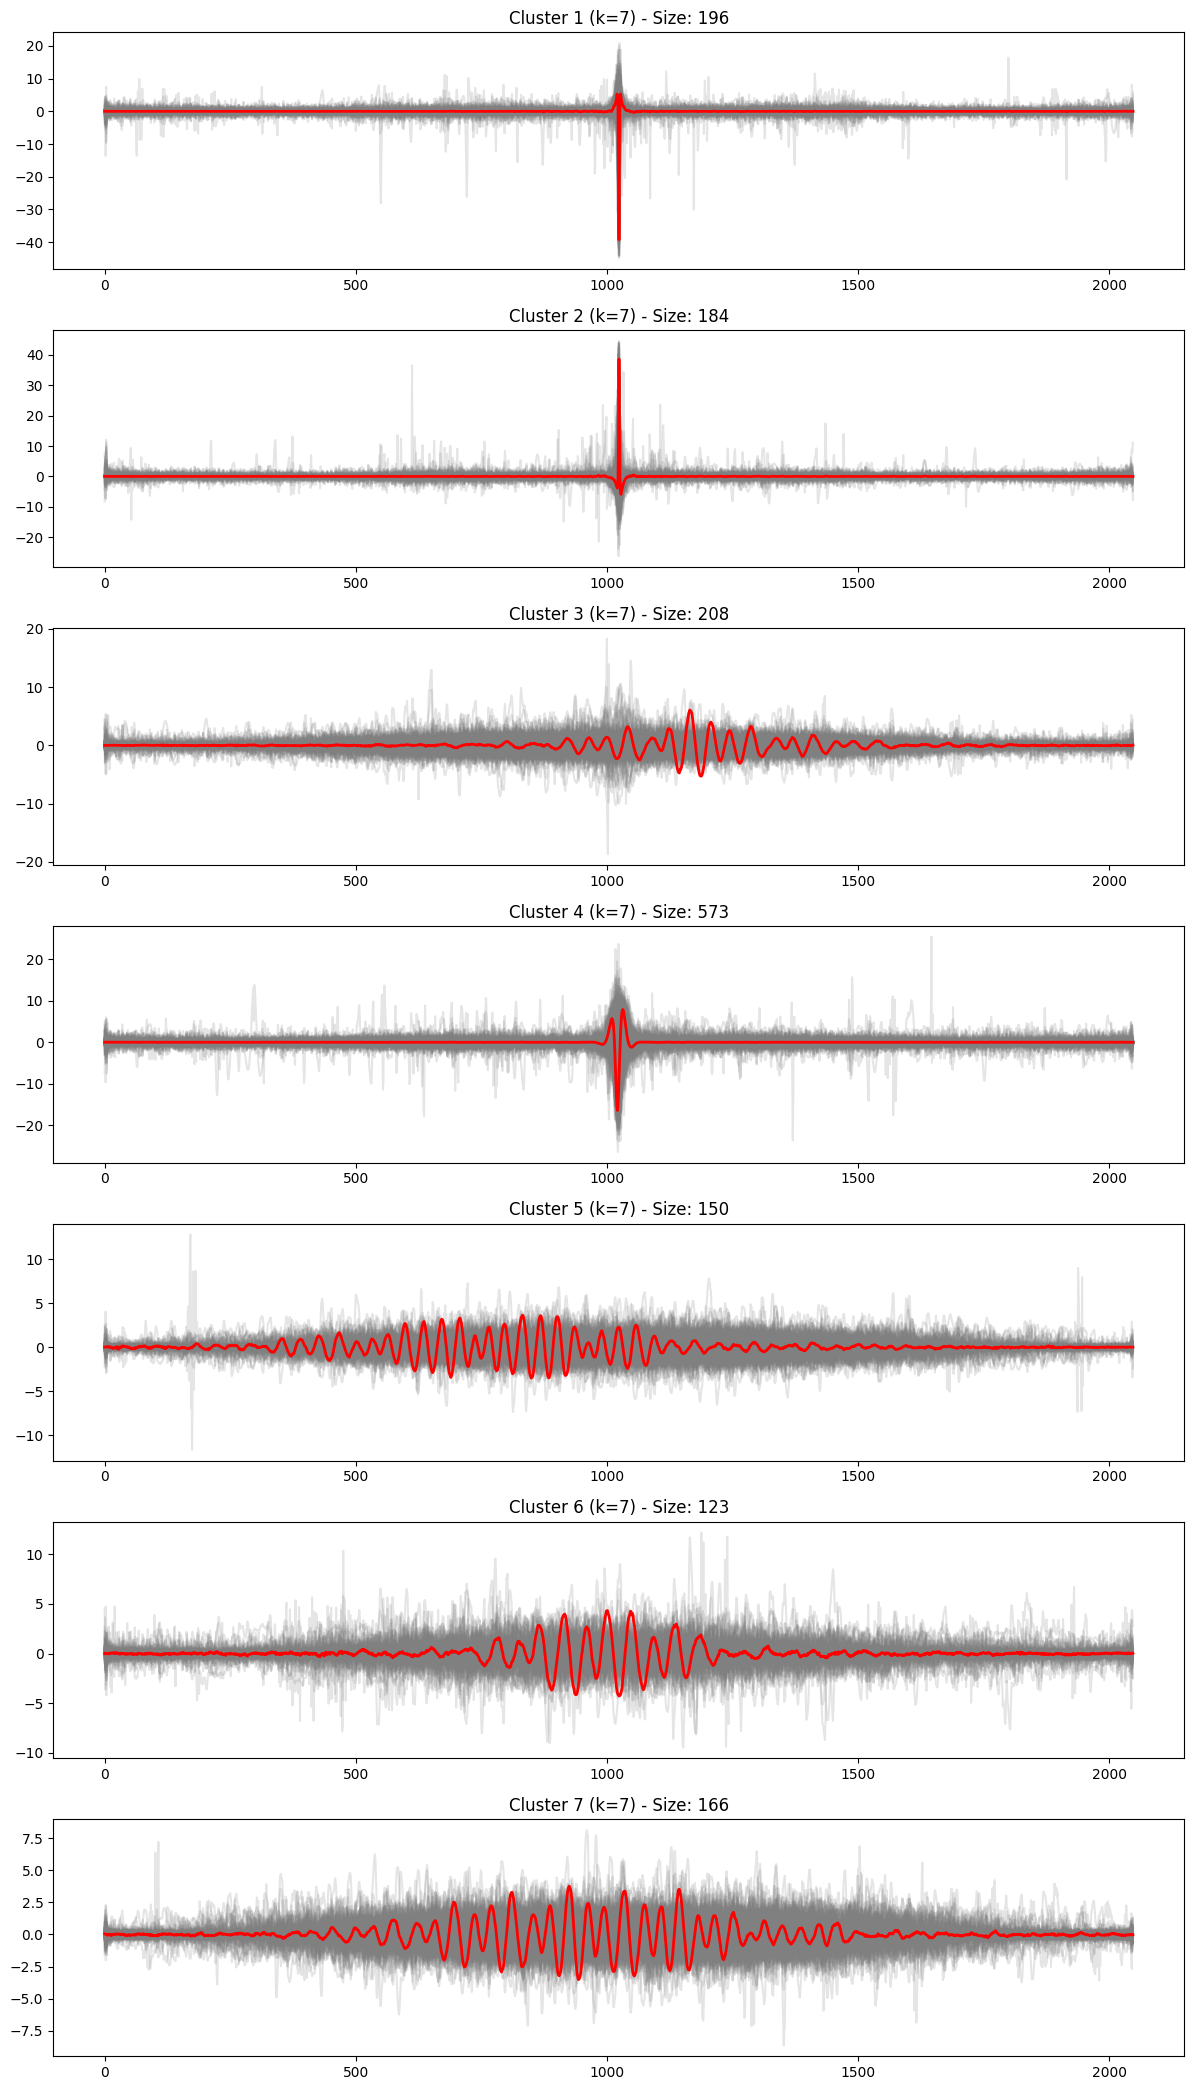

In [376]:
# drawing function for visualizing cluster centroids and collection of time series in each cluster
def plot_clusters(ks_model, X_ts, y_pred, k):
    n_clusters = ks_model.n_clusters
    fig, axes = plt.subplots(n_clusters, 1, figsize=(12, 3 * n_clusters))
    if n_clusters == 1:
        axes = [axes]
    for cluster_idx in range(n_clusters):
        ax = axes[cluster_idx]
        cluster_members = X_ts[y_pred == cluster_idx]
        for ts in cluster_members:
            ax.plot(ts.ravel(), color='gray', alpha=0.2)
        centroid = ks_model.cluster_centers_[cluster_idx]
        ax.plot(centroid.ravel(), color='red', linewidth=2)
        ax.set_title(f'Cluster {cluster_idx + 1} (k={k}) - Size: {cluster_members.shape[0]}')
    plt.tight_layout()
    plt.show()

plot_clusters(ks_best, X_train_ts_scaled, y_pred_ks_best, kbest)

In [369]:
for i in range(len(ghat_labels_uq)):
    cls_i = X_train_ts_scaled[label_train == ghat_labels_uq[i]]
    print(f"Class {ghat_labels_uq[i]} size: {cls_i.shape[0]}")

Class Blip size: 137
Class Koi_Fish size: 228
Class Scattered_Light size: 751
Class Tomte size: 484


In [ ]:
# compute silhouette score to evaluate clustering performance !!!VERY SLOW!!!

# first define KShape distance metric SBD
from tslearn.metrics import cdist_normalized_cc

def sbd_distance_matrix(X,Y):
    X_norms = np.linalg.norm(X,axis=(1,2))
    Y_norms = np.linalg.norm(Y,axis=(1,2))
    ncc_matrix = cdist_normalized_cc(X,Y,norms1=X_norms,norms2=Y_norms,self_similarity=False)
    return 1. - ncc_matrix

# compute distance matrix for training set
dist = sbd_distance_matrix(X_train_ts_scaled,X_train_ts_scaled)
print(dist.shape)

(1600, 1600)


In [ ]:
# compute silhouette score
from tslearn.clustering import silhouette_score

dist_modified = dist.copy()
for i in range(dist.shape[0]):
    dist_modified[i,i] = 0.0 ## set diagonal to zero; which should be zero for diagonal elements(distance to itself)

dist_modified[77,447] = 0.
dist_modified[447,77] = 0. # two distinct negative distances (1e-6) set to zero

s_score_initialized = silhouette_score(dist_modified, y_pred_ks, metric="precomputed")
print(f"Silhouette score for KShape with initialized centroids: {s_score_initialized}")

Silhouette score for KShape with initialized centroids: 0.2599402796609082


In [171]:
s_score_random = silhouette_score(dist_modified, y_pred_ks_random, metric="precomputed")
print(f"Silhouette score for KShape with random initialization: {s_score_random}")

Silhouette score for KShape with random initialization: 0.24659707319872368


In [ ]:
# test other measurements in distance matrix computation !!! DO NOT TRY extremely slow O(L^2)!!!
s_score_softdtw = silhouette_score(X_train_ts_scaled,y_pred_ks,metric="softdtw")
print(s_score_softdtw)

(1600,)
(1600,)


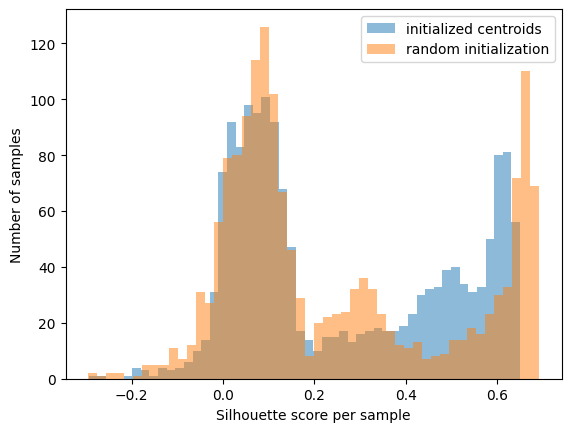

In [177]:
# silhouette scores for each sample
from sklearn.metrics import silhouette_samples

s_samples_initialized = silhouette_samples(dist_modified, y_pred_ks, metric="precomputed")
s_samples_random = silhouette_samples(dist_modified, y_pred_ks_random, metric="precomputed")
print(s_samples_initialized.shape)
print(s_samples_random.shape)
plt.hist(s_samples_initialized,bins=50,alpha=0.5,label='initialized centroids')
plt.hist(s_samples_random,bins=50,alpha=0.5,label='random initialization')
plt.xlabel("Silhouette score per sample")
plt.ylabel("Number of samples")
plt.legend()
plt.show()

In [98]:
from tslearn.metrics import cdist_normalized_cc

ncc = cdist_normalized_cc(np.array(X_train_ts_scaled[1]).reshape(1,2048,1),np.array(ks.cluster_centers_[1]).reshape(1,2048,1),norms1=ks.norms_,norms2=ks.norms_centroids_,self_similarity=False)
print(ncc)

ncc1 = cdist_normalized_cc(X_train_ts_scaled,ks.cluster_centers_,norms1=ks.norms_,norms2=ks.norms_centroids_,self_similarity=False)
print(ncc1[1])
print(np.argmax(ncc1,axis=1)[:10])
print(np.argmin(ks._cross_dists(X_train_ts_scaled),axis=1)[:10])
print(ks.labels_[:10])
cdist_normalized_cc(np.array(X_train_ts_scaled[1]).reshape(1,2048,1),np.array(X_train_ts_scaled[1]).reshape(1,2048,1),norms1=ks.norms_,norms2=ks.norms_centroids_,self_similarity=False)


[[0.44473317]]
[0.21311506 0.44473317 0.30378181 0.88902776]
[2 3 2 3 1 3 3 2 1 3]
[2 3 2 3 1 3 3 2 1 3]
[2 3 2 3 1 3 3 2 1 3]


array([[1.]])

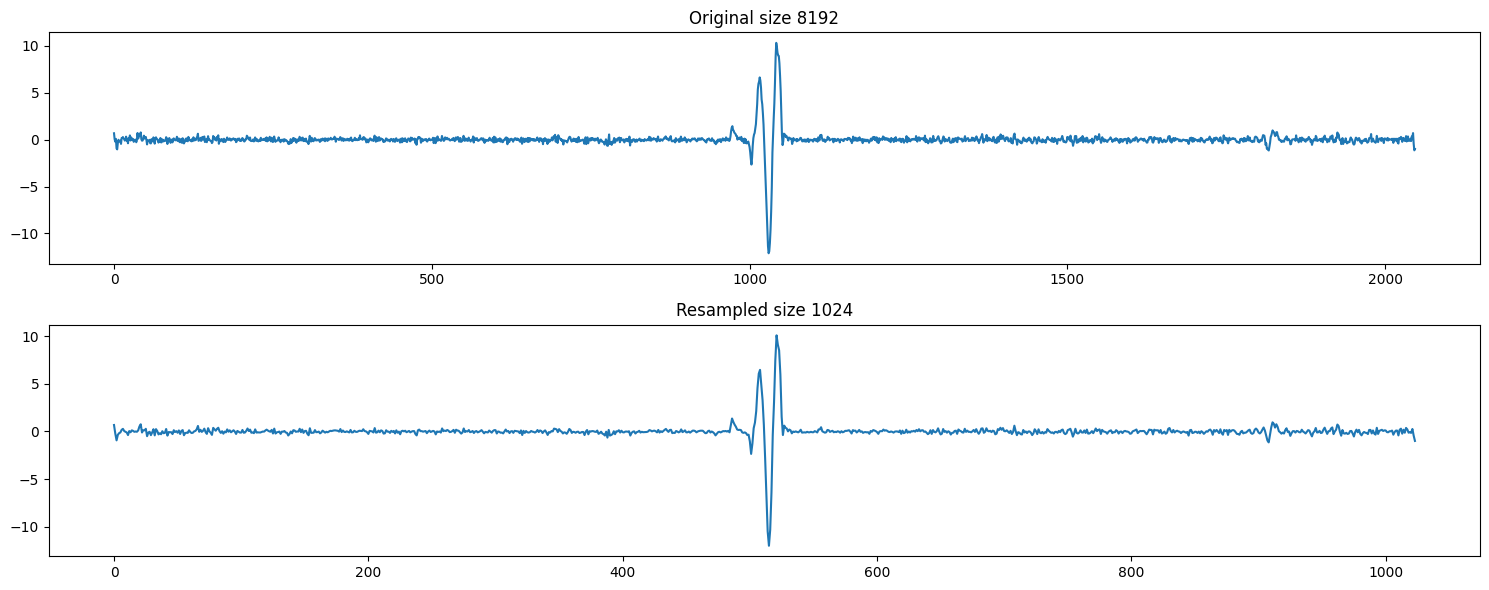

2048 1024


In [378]:
# Example of resampling time series to a different length for quicker KShape clustering
from tslearn.preprocessing import TimeSeriesResampler

target_sz = 1024
X_resampled = TimeSeriesResampler(sz=target_sz).fit_transform(X_train_ts_scaled)

plt.figure(figsize=(15,6))

plt.subplot(2,1,1)
plt.plot(X_train_ts_scaled[191].ravel())
plt.title("Original size 8192")

plt.subplot(2,1,2)
plt.plot(X_resampled[191].ravel())
plt.title(f"Resampled size {target_sz}")

plt.tight_layout()
plt.show()

print(X_train_ts_scaled.shape[1],X_resampled.shape[1])

In [53]:
X_types = []
for i in range(len(ghat_labels_uq)):
    X_types.append(X_train_ts_scaled[label_train == ghat_labels_uq[i]])
sumx = 0
X_init = []
for i in range(len(X_types)):
    sumx += X_types[i].shape[0]
    print(X_types[i].shape[0])
    X_init.append(X_types[i][np.random.randint(X_types[i].shape[0])])
print(sumx)
print(np.array(X_init).shape)


137
228
751
484
1600
(4, 2048, 1)


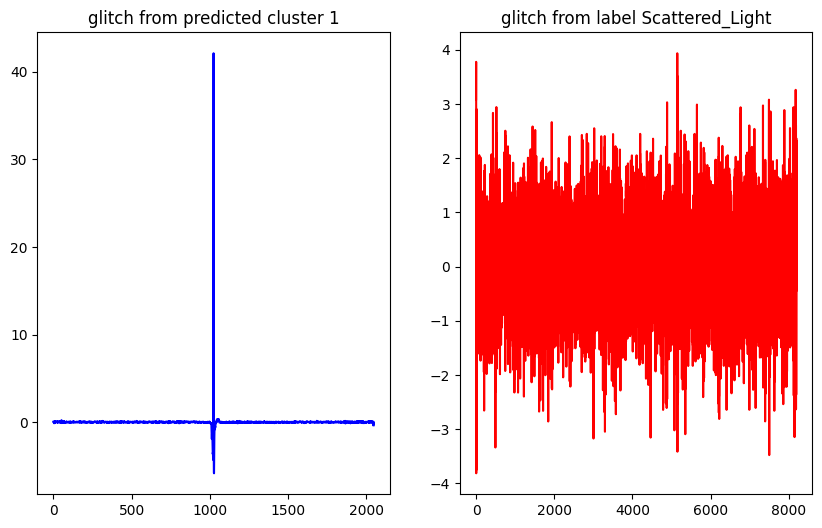

In [14]:
rand_type1_glitch_pred = X_train_ts_scaled[y_pred_ks == 0][np.random.randint(X_train_ts_scaled[y_pred_ks == 0].shape[0])].ravel()
rand_type1_glitch_orig = X_train_ts[label_train == ghat_labels_uq[2]][np.random.randint(X_train_ts[label_train == ghat_labels_uq[0]].shape[0])].ravel()
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(rand_type1_glitch_pred,"b-")
plt.title(f"glitch from predicted cluster 1")
plt.subplot(1,2,2)
plt.plot(rand_type1_glitch_orig,"r-")
plt.title(f"glitch from label {ghat_labels_uq[2]}")
plt.show()

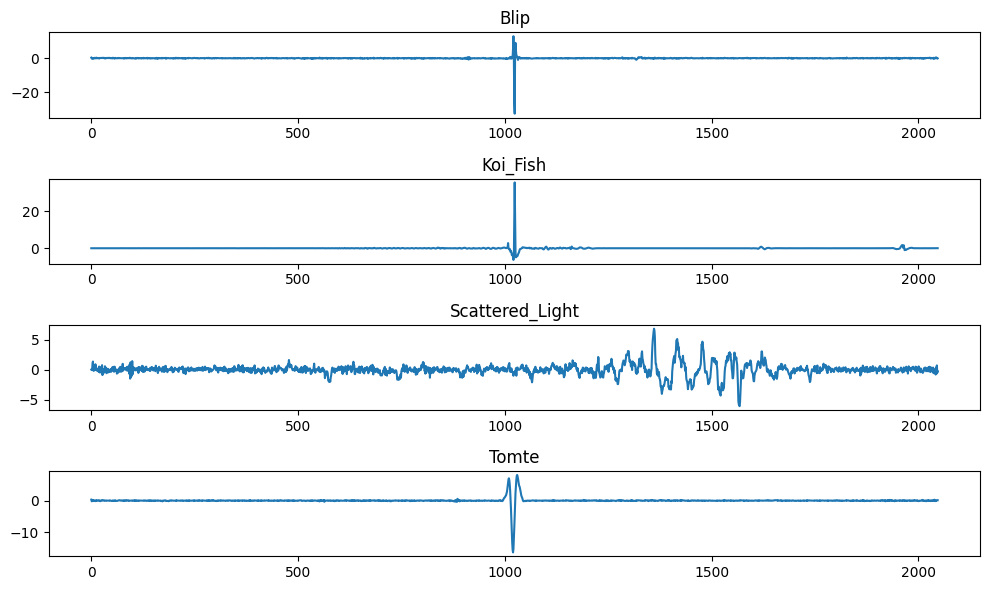

In [ ]:
# Plot random examples from each known glitch class after normalization and scaling
plt.figure(figsize=(10,6))
for i in range(len(ghat_labels_uq)):
    picked = X_train_ts_scaled[label_train == ghat_labels_uq[i]]
    plt.subplot(len(ghat_labels_uq),1,i+1)
    plt.plot(picked[np.random.randint(len(picked))].ravel())
    plt.title(f"{ghat_labels_uq[i]}")

plt.tight_layout()
plt.show()